# OpenDrift forcing

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
from itertools import repeat
from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift
from salishsea_tools import viz_tools

#%matplotlib inline
plt.rcParams['font.size'] = 12

***

### Required forcing for OceanDrift module

In [3]:
# OceanDrift require variables
OceanDrift.required_variables

['x_sea_water_velocity',
 'y_sea_water_velocity',
 'x_wind',
 'y_wind',
 'land_binary_mask']

***
### Define paths

In [3]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'out': '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

***

### Prefix constructor for SSC

In [4]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

***

### Begin forcing processing

In [5]:
# Date
date = datetime(2019, 1, 1)

### NEMO

In [7]:
# Open NEMO velocity results as a list of raw=[u,v]
prefix = make_prefix(date, paths)
NEMO_out = os.path.join(paths['out'], os.path.split(prefix)[-1] + '_opendrift.nc')
raw = []
for k, key in zip(['U', 'V'], ['vozocrtx', 'vomecrty']):
    with xr.open_dataset(prefix + f'_grid_{k}.nc') as data:
        raw.append(data[key][:, 0, ...].values)
        if k is 'U': time = data.time_counter

# Unstagger and rotate NEMO velocities
u, v = viz_tools.rotate_vel(*viz_tools.unstagger(*raw))

# Save NEMO velocities
xr.Dataset(
    {
        'longitude': ('flat', mask.nav_lon[1:, 1:].values.reshape(-1)),
        'latitude': ('flat', mask.nav_lat[1:, 1:].values.reshape(-1)),
        'meshmask': ('flat', mask.tmask[0, 0, 1:, 1:].values.reshape(-1), {'standard_name': 'land_binary_mask'}),
        'u': (['time_counter', 'flat'], u.reshape(time.size, -1), {'standard_name': 'x_sea_water_velocity'}),
        'v': (['time_counter', 'flat'], v.reshape(time.size, -1), {'standard_name': 'y_sea_water_velocity'}),
    },
    coords={'time_counter': time}
).to_netcdf(NEMO_out)

### HRDPS

In [8]:
# Open HRDPS results and save flattened to netCDF
datestr = date.strftime('ops_y%Ym%md%d.nc')
HRDPS_out = os.path.join(paths['out'], datestr)
with xr.open_dataset(os.path.join(paths['HRDPS'], datestr)) as data:
    time = data.time_counter
    time.attrs['standard_name'] = 'time'
    xr.Dataset(
        {
            'longitude': ('flat', data.nav_lon.values.reshape(-1)),
            'latitude': ('flat', data.nav_lat.values.reshape(-1)),
            'u_wind': (['time_counter', 'flat'], data.u_wind.values.reshape(time.size, -1), {'standard_name': 'x_wind'}),
            'v_wind': (['time_counter', 'flat'], data.v_wind.values.reshape(time.size, -1), {'standard_name': 'y_wind'}),
        },
        coords={'time_counter': time},
    ).to_netcdf(HRDPS_out)

***

### Reading forcing files

In [8]:
# Read forcing
reader_NEMO = reader_netCDF_CF_unstructured.Reader(NEMO_out)

In [9]:
# Read forcing
reader_HRDPS = reader_netCDF_CF_unstructured.Reader(HRDPS_out)

In [10]:
o = OceanDrift()

16:26:24 INFO: OpenDriftSimulation initialised (version 1.0.6)


In [11]:
o.add_reader([reader_NEMO, reader_HRDPS])

16:26:24 DEBUG: Calculation SRS set to: +units=m +proj=latlong +ellps=WGS84
16:26:24 DEBUG: Using srs for common grid: +proj=latlong
16:26:24 DEBUG: Added reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
16:26:24 DEBUG: Added reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc


In [12]:
o.seed_elements(-123.5, 49.2, radius=500, number=100, time=reader_NEMO.start_time, wind_drift_factor=0.03)

In [13]:
o.run(time_step=timedelta(minutes=15), time_step_output=timedelta(minutes=60))

16:26:26 DEBUG: 
------------------------------------------------------
Software and hardware:
  OpenDrift version 1.0.6
  251.8831558227539 GB memory
  32 processors (x86_64)
  Basemap version 1.0.7
  NumPy version 1.14.2
  SciPy version 0.19.1
  Matplotlib version 2.1.0
  NetCDF4 version 1.4.0
  Python version 3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) [GCC 7.3.0]
------------------------------------------------------

16:26:26 INFO: Config validation OK
16:26:26 DEBUG: No output file is specified, neglecting export_buffer_length
16:26:26 INFO: Duration, steps or end time not specified, running until end of first reader: 2019-01-01 23:30:00
16:26:26 INFO: Duration, steps or end time not specified, running until end of first reader: 2019-01-01 23:00:00
16:26:26 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
16:26:26 INFO: No display found. Using non-interactive Agg backend

16:26:36 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name, self.coverage_string()))
ValueError: All 100 particles (-123.52--123.48E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)

16:26:36 INFO: ========================
16:26:36 DEBUG: ----------------------------------------
16:26:36 DEBUG: Variable group ['land_binary_mask']
16:26:36 DEBUG: ----------------------------------------
16:26:36 DEBUG: Calling reader basemap_landmask
16:26:36 DEBUG: ----------------------------------------
16:26:36 DEBUG: Data needed for 100 elements
16:26:36 DEBUG: Reader time:
		None (before)
		None (after)
16:26:36 DEB

16:26:36 DEBUG: ----------------------------------------
16:26:36 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
16:26:36 DEBUG: ----------------------------------------
16:26:36 DEBUG: Data needed for 100 elements
16:26:36 INFO: ========================
16:26:36 INFO: Exception:
16:26:36 INFO: All 100 particles (-123.51--123.48E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)
16:26:36 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name, self.coverage_string()))
ValueError: All 100 particles (-123.51--123.48E, 49.19-49.21N) are outside domain o

16:26:36 DEBUG: ----------------------------------------
16:26:37 DEBUG: Variable group ['x_wind', 'y_wind']
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Data needed for 100 elements
16:26:37 INFO: ========================
16:26:37 INFO: Exception:
16:26:37 INFO: All 100 particles (-123.51--123.47E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)
16:26:37 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name,

16:26:37 DEBUG: Interpolating before (2019-01-01 01:30:00) in space  (linearNDFast)
16:26:37 DEBUG: Initialising interpolator.
16:26:37 DEBUG: Interpolating after (2019-01-01 02:30:00) in space  (linearNDFast)
16:26:37 DEBUG: Initialising interpolator.
16:26:37 DEBUG: Interpolating before (2019-01-01 01:30:00, weight 0.50) and
		      after (2019-01-01 02:30:00, weight 0.50) in time
16:26:37 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
16:26:37 DEBUG: Obtained data for all elements.
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Variable group ['x_wind', 'y_wind']
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Data needed for 100 elements
16:26:37 INFO: ========================
16:26:37 INFO: Exception:
16:26:37 INFO: All 

16:26:37 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Data needed for 100 elements
16:26:37 DEBUG: Reader time:
		2019-01-01 02:30:00 (before)
		2019-01-01 03:30:00 (after)
16:26:37 DEBUG: Interpolating before (2019-01-01 02:30:00) in space  (linearNDFast)
16:26:37 DEBUG: Initialising interpolator.
16:26:37 DEBUG: No time interpolation needed - right on time.
16:26:37 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
16:26:37 DEBUG: Obtained data for all elements.
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Variable group ['x_wind', 'y_wind']
16:26:37 DEBUG: ----------------------------------------
16:26:37 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
16:26:37 DEBUG: ---------------------------------

16:26:38 INFO: 2019-01-01 03:00:00 - step 11 of 90 - 100 active elements (0 deactivated)
16:26:38 DEBUG: 0 elements scheduled.
16:26:38 DEBUG: ======================================================================
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Data needed for 100 elements
16:26:38 DEBUG: Reader time:
		2019-01-01 02:30:00 (before)
		2019-01-01 03:30:00 (after)
16:26:38 DEBUG: Interpolating before (2019-01-01 02:30:00) in space  (linearNDFast)
16:26:38 DEBUG: Initialising interpolator.
16:26:38 DEBUG: Interpolating after (2019-01-01 03:30:00) in space  (linearNDFast)
16:26:38 DEBUG: Initialising interpolator.
16:2

16:26:38 DEBUG: No elements to deactivate
16:26:38 DEBUG: Calling OceanDrift.update()
16:26:38 DEBUG: No wind for wind-sheared ocean drift
16:26:38 DEBUG: 100 active elements (0 deactivated)
16:26:38 DEBUG: to be seeded: 0, already seeded 100
16:26:38 DEBUG: ======================================================================
16:26:38 INFO: 2019-01-01 03:30:00 - step 13 of 90 - 100 active elements (0 deactivated)
16:26:38 DEBUG: 0 elements scheduled.
16:26:38 DEBUG: ======================================================================
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
16:26:38 DEBUG: ----------------------------------------
16:26:38 DEBUG: Data needed for 100 elements
16:26:38 DEBUG: R

16:26:39 DEBUG: ---------------------------------------
16:26:39 DEBUG: Finished processing all variable groups
16:26:39 DEBUG: ------------ SUMMARY -------------
16:26:39 DEBUG:     x_sea_water_velocity: 0.0835234 (min) 0.141923 (max)
16:26:39 DEBUG:     y_sea_water_velocity: -0.0299682 (min) 0.0161495 (max)
16:26:39 DEBUG:     x_wind: 0 (min) 0 (max)
16:26:39 DEBUG:     y_wind: 0 (min) 0 (max)
16:26:39 DEBUG:     land_binary_mask: 0 (min) 0 (max)
16:26:39 DEBUG: ---------------------------------
16:26:39 DEBUG: 		100 active elements
16:26:39 DEBUG: 		49.17896764309794 <- latitude  -> 49.200668492632424
16:26:39 DEBUG: 		-123.48007064851424 <- longitude -> -123.45050049865664
16:26:39 DEBUG: 		z = 0.0
16:26:39 DEBUG: ---------------------------------
16:26:39 DEBUG: No elements to deactivate
16:26:39 DEBUG: Calling OceanDrift.update()
16:26:39 DEBUG: No wind for wind-sheared ocean drift
16:26:39 DEBUG: 100 active elements (0 deactivated)
16:26:39 DEBUG: to be seeded: 0, already seeded

16:26:39 DEBUG: ----------------------------------------
16:26:39 DEBUG: Data needed for 100 elements
16:26:39 DEBUG: Reader time:
		None (before)
		None (after)
16:26:39 DEBUG: Fetching variables from basemap_landmask
16:26:39 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:39 DEBUG: Fetched env-before
16:26:39 DEBUG: No time interpolation needed - right on time.
16:26:39 DEBUG: Obtained data for all elements.
16:26:39 DEBUG: ---------------------------------------
16:26:39 DEBUG: Finished processing all variable groups
16:26:39 DEBUG: ------------ SUMMARY -------------
16:26:39 DEBUG:     x_sea_water_velocity: 0.062779 (min) 0.128757 (max)
16:26:39 DEBUG:     y_sea_water_velocity: 0.00958455 (min) 0.0586029 (max)
16:26:39 DEBUG:     x_wind: 0 (min) 0 (max)
16:26:39 DEBUG:     y_wind: 0 (min) 0 (max)
16:26:39 DEBUG:     land_binary_mask: 0 (min) 0 (max)
16:26:39 DEBUG: ---------------------------------
16:26:39 DEBUG: 		100 active elements
16:26:39 DEBUG: 		49.17906060095985 <-

16:26:39 INFO: ========================
16:26:39 DEBUG: ----------------------------------------
16:26:39 DEBUG: Variable group ['land_binary_mask']
16:26:39 DEBUG: ----------------------------------------
16:26:39 DEBUG: Calling reader basemap_landmask
16:26:39 DEBUG: ----------------------------------------
16:26:39 DEBUG: Data needed for 100 elements
16:26:39 DEBUG: Reader time:
		None (before)
		None (after)
16:26:39 DEBUG: Fetching variables from basemap_landmask
16:26:39 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:39 DEBUG: Fetched env-before
16:26:39 DEBUG: No time interpolation needed - right on time.
16:26:39 DEBUG: Obtained data for all elements.
16:26:39 DEBUG: ---------------------------------------
16:26:39 DEBUG: Finished processing all variable groups
16:26:39 DEBUG: ------------ SUMMARY -------------
16:26:39 DEBUG:     x_sea_water_velocity: 0.0491253 (min) 0.118543 (max)
16:26:39 DEBUG:     y_sea_water_velocity: 0.0461147 (min) 0.097282 (max)
16:26:39 DEBUG:

16:26:40 INFO: ========================
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Variable group ['land_binary_mask']
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Calling reader basemap_landmask
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Data needed for 100 elements
16:26:40 DEBUG: Reader time:
		None (before)
		None (after)
16:26:40 DEBUG: Fetching variables from basemap_landmask
16:26:40 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:40 DEBUG: Fetched env-before
16:26:40 DEBUG: No time interpolation needed - right on time.
16:26:40 DEBUG: Obtained data for all elements.
16:26:40 DEBUG: ---------------------------------------
16:26:40 DEBUG: Finished processing all variable groups
16:26:40 DEBUG: ------------ SUMMARY -------------
16:26:40 DEBUG:     x_sea_water_velocity: 0.0457936 (min) 0.112429 (max)
16:26:40 DEBUG:     y_sea_water_velocity: 0.0748378 (min) 0.134827 (max)
16:26:40 DEBUG:

16:26:40 INFO: ========================
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Variable group ['land_binary_mask']
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Calling reader basemap_landmask
16:26:40 DEBUG: ----------------------------------------
16:26:40 DEBUG: Data needed for 100 elements
16:26:40 DEBUG: Reader time:
		None (before)
		None (after)
16:26:40 DEBUG: Fetching variables from basemap_landmask
16:26:40 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:40 DEBUG: Fetched env-before
16:26:40 DEBUG: No time interpolation needed - right on time.
16:26:40 DEBUG: Obtained data for all elements.
16:26:40 DEBUG: ---------------------------------------
16:26:40 DEBUG: Finished processing all variable groups
16:26:40 DEBUG: ------------ SUMMARY -------------
16:26:40 DEBUG:     x_sea_water_velocity: 0.0483794 (min) 0.11376 (max)
16:26:40 DEBUG:     y_sea_water_velocity: 0.0969496 (min) 0.171857 (max)
16:26:40 DEBUG: 

16:26:41 INFO: ========================
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Variable group ['land_binary_mask']
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Calling reader basemap_landmask
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Data needed for 100 elements
16:26:41 DEBUG: Reader time:
		None (before)
		None (after)
16:26:41 DEBUG: Fetching variables from basemap_landmask
16:26:41 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:41 DEBUG: Fetched env-before
16:26:41 DEBUG: No time interpolation needed - right on time.
16:26:41 DEBUG: Obtained data for all elements.
16:26:41 DEBUG: ---------------------------------------
16:26:41 DEBUG: Finished processing all variable groups
16:26:41 DEBUG: ------------ SUMMARY -------------
16:26:41 DEBUG:     x_sea_water_velocity: 0.0557433 (min) 0.122 (max)
16:26:41 DEBUG:     y_sea_water_velocity: 0.106093 (min) 0.189891 (max)
16:26:41 DEBUG:    

16:26:41 INFO: ========================
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Variable group ['land_binary_mask']
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Calling reader basemap_landmask
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Data needed for 100 elements
16:26:41 DEBUG: Reader time:
		None (before)
		None (after)
16:26:41 DEBUG: Fetching variables from basemap_landmask
16:26:41 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:41 DEBUG: Fetched env-before
16:26:41 DEBUG: No time interpolation needed - right on time.
16:26:41 DEBUG: Obtained data for all elements.
16:26:41 DEBUG: ---------------------------------------
16:26:41 DEBUG: Finished processing all variable groups
16:26:41 DEBUG: ------------ SUMMARY -------------
16:26:41 DEBUG:     x_sea_water_velocity: 0.0641659 (min) 0.136936 (max)
16:26:41 DEBUG:     y_sea_water_velocity: 0.102246 (min) 0.194779 (max)
16:26:41 DEBUG: 

16:26:41 INFO: ========================
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Variable group ['land_binary_mask']
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Calling reader basemap_landmask
16:26:41 DEBUG: ----------------------------------------
16:26:41 DEBUG: Data needed for 100 elements
16:26:41 DEBUG: Reader time:
		None (before)
		None (after)
16:26:41 DEBUG: Fetching variables from basemap_landmask
16:26:41 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:41 DEBUG: Fetched env-before
16:26:41 DEBUG: No time interpolation needed - right on time.
16:26:41 DEBUG: Obtained data for all elements.
16:26:41 DEBUG: ---------------------------------------
16:26:41 DEBUG: Finished processing all variable groups
16:26:41 DEBUG: ------------ SUMMARY -------------
16:26:41 DEBUG:     x_sea_water_velocity: 0.0836242 (min) 0.141447 (max)
16:26:41 DEBUG:     y_sea_water_velocity: 0.0925119 (min) 0.18977 (max)
16:26:41 DEBUG: 

16:26:42 INFO: ========================
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Variable group ['land_binary_mask']
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Calling reader basemap_landmask
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Data needed for 100 elements
16:26:42 DEBUG: Reader time:
		None (before)
		None (after)
16:26:42 DEBUG: Fetching variables from basemap_landmask
16:26:42 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:42 DEBUG: Fetched env-before
16:26:42 DEBUG: No time interpolation needed - right on time.
16:26:42 DEBUG: Obtained data for all elements.
16:26:42 DEBUG: ---------------------------------------
16:26:42 DEBUG: Finished processing all variable groups
16:26:42 DEBUG: ------------ SUMMARY -------------
16:26:42 DEBUG:     x_sea_water_velocity: 0.110264 (min) 0.141002 (max)
16:26:42 DEBUG:     y_sea_water_velocity: 0.0782817 (min) 0.173979 (max)
16:26:42 DEBUG: 

16:26:42 INFO: ========================
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Variable group ['land_binary_mask']
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Calling reader basemap_landmask
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Data needed for 100 elements
16:26:42 DEBUG: Reader time:
		None (before)
		None (after)
16:26:42 DEBUG: Fetching variables from basemap_landmask
16:26:42 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:42 DEBUG: Fetched env-before
16:26:42 DEBUG: No time interpolation needed - right on time.
16:26:42 DEBUG: Obtained data for all elements.
16:26:42 DEBUG: ---------------------------------------
16:26:42 DEBUG: Finished processing all variable groups
16:26:42 DEBUG: ------------ SUMMARY -------------
16:26:42 DEBUG:     x_sea_water_velocity: 0.111969 (min) 0.150267 (max)
16:26:42 DEBUG:     y_sea_water_velocity: 0.0633883 (min) 0.153973 (max)
16:26:42 DEBUG: 

16:26:42 INFO: ========================
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Variable group ['land_binary_mask']
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Calling reader basemap_landmask
16:26:42 DEBUG: ----------------------------------------
16:26:42 DEBUG: Data needed for 100 elements
16:26:42 DEBUG: Reader time:
		None (before)
		None (after)
16:26:42 DEBUG: Fetching variables from basemap_landmask
16:26:42 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:42 DEBUG: Fetched env-before
16:26:42 DEBUG: No time interpolation needed - right on time.
16:26:42 DEBUG: Obtained data for all elements.
16:26:42 DEBUG: ---------------------------------------
16:26:42 DEBUG: Finished processing all variable groups
16:26:42 DEBUG: ------------ SUMMARY -------------
16:26:42 DEBUG:     x_sea_water_velocity: 0.11684 (min) 0.158164 (max)
16:26:42 DEBUG:     y_sea_water_velocity: 0.0427992 (min) 0.137681 (max)
16:26:42 DEBUG:  

16:26:43 INFO: ========================
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Variable group ['land_binary_mask']
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Calling reader basemap_landmask
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Data needed for 100 elements
16:26:43 DEBUG: Reader time:
		None (before)
		None (after)
16:26:43 DEBUG: Fetching variables from basemap_landmask
16:26:43 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:43 DEBUG: Fetched env-before
16:26:43 DEBUG: No time interpolation needed - right on time.
16:26:43 DEBUG: Obtained data for all elements.
16:26:43 DEBUG: ---------------------------------------
16:26:43 DEBUG: Finished processing all variable groups
16:26:43 DEBUG: ------------ SUMMARY -------------
16:26:43 DEBUG:     x_sea_water_velocity: 0.11649 (min) 0.165529 (max)
16:26:43 DEBUG:     y_sea_water_velocity: 0.0270052 (min) 0.121846 (max)
16:26:43 DEBUG:  

16:26:43 INFO: ========================
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Variable group ['land_binary_mask']
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Calling reader basemap_landmask
16:26:43 DEBUG: ----------------------------------------
16:26:43 DEBUG: Data needed for 100 elements
16:26:43 DEBUG: Reader time:
		None (before)
		None (after)
16:26:43 DEBUG: Fetching variables from basemap_landmask
16:26:43 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:43 DEBUG: Fetched env-before
16:26:43 DEBUG: No time interpolation needed - right on time.
16:26:43 DEBUG: Obtained data for all elements.
16:26:43 DEBUG: ---------------------------------------
16:26:43 DEBUG: Finished processing all variable groups
16:26:43 DEBUG: ------------ SUMMARY -------------
16:26:43 DEBUG:     x_sea_water_velocity: 0.12812 (min) 0.169837 (max)
16:26:43 DEBUG:     y_sea_water_velocity: 0.0181074 (min) 0.108894 (max)
16:26:43 DEBUG:  

16:26:44 INFO: ========================
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Variable group ['land_binary_mask']
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Calling reader basemap_landmask
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Data needed for 100 elements
16:26:44 DEBUG: Reader time:
		None (before)
		None (after)
16:26:44 DEBUG: Fetching variables from basemap_landmask
16:26:44 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:44 DEBUG: Fetched env-before
16:26:44 DEBUG: No time interpolation needed - right on time.
16:26:44 DEBUG: Obtained data for all elements.
16:26:44 DEBUG: ---------------------------------------
16:26:44 DEBUG: Finished processing all variable groups
16:26:44 DEBUG: ------------ SUMMARY -------------
16:26:44 DEBUG:     x_sea_water_velocity: 0.132268 (min) 0.173032 (max)
16:26:44 DEBUG:     y_sea_water_velocity: 0.0109393 (min) 0.0955394 (max)
16:26:44 DEBUG:

16:26:44 INFO: ========================
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Variable group ['land_binary_mask']
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Calling reader basemap_landmask
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Data needed for 100 elements
16:26:44 DEBUG: Reader time:
		None (before)
		None (after)
16:26:44 DEBUG: Fetching variables from basemap_landmask
16:26:44 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:44 DEBUG: Fetched env-before
16:26:44 DEBUG: No time interpolation needed - right on time.
16:26:44 DEBUG: Obtained data for all elements.
16:26:44 DEBUG: ---------------------------------------
16:26:44 DEBUG: Finished processing all variable groups
16:26:44 DEBUG: ------------ SUMMARY -------------
16:26:44 DEBUG:     x_sea_water_velocity: 0.120224 (min) 0.176886 (max)
16:26:44 DEBUG:     y_sea_water_velocity: 0.0016993 (min) 0.074708 (max)
16:26:44 DEBUG: 

16:26:44 INFO: ========================
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Variable group ['land_binary_mask']
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Calling reader basemap_landmask
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Data needed for 100 elements
16:26:44 DEBUG: Reader time:
		None (before)
		None (after)
16:26:44 DEBUG: Fetching variables from basemap_landmask
16:26:44 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:44 DEBUG: Fetched env-before
16:26:44 DEBUG: No time interpolation needed - right on time.
16:26:44 DEBUG: Obtained data for all elements.
16:26:44 DEBUG: ---------------------------------------
16:26:44 DEBUG: Finished processing all variable groups
16:26:44 DEBUG: ------------ SUMMARY -------------
16:26:44 DEBUG:     x_sea_water_velocity: 0.109909 (min) 0.173968 (max)
16:26:44 DEBUG:     y_sea_water_velocity: -0.00454591 (min) 0.0585054 (max)
16:26:44 DEBU

16:26:44 INFO: ========================
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Variable group ['land_binary_mask']
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Calling reader basemap_landmask
16:26:44 DEBUG: ----------------------------------------
16:26:44 DEBUG: Data needed for 100 elements
16:26:44 DEBUG: Reader time:
		None (before)
		None (after)
16:26:44 DEBUG: Fetching variables from basemap_landmask
16:26:44 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:44 DEBUG: Fetched env-before
16:26:44 DEBUG: No time interpolation needed - right on time.
16:26:44 DEBUG: Obtained data for all elements.
16:26:44 DEBUG: ---------------------------------------
16:26:44 DEBUG: Finished processing all variable groups
16:26:44 DEBUG: ------------ SUMMARY -------------
16:26:44 DEBUG:     x_sea_water_velocity: 0.102088 (min) 0.162115 (max)
16:26:44 DEBUG:     y_sea_water_velocity: -0.010179 (min) 0.047322 (max)
16:26:44 DEBUG: 

16:26:45 INFO: ========================
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Variable group ['land_binary_mask']
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Calling reader basemap_landmask
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Data needed for 100 elements
16:26:45 DEBUG: Reader time:
		None (before)
		None (after)
16:26:45 DEBUG: Fetching variables from basemap_landmask
16:26:45 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:45 DEBUG: Fetched env-before
16:26:45 DEBUG: No time interpolation needed - right on time.
16:26:45 DEBUG: Obtained data for all elements.
16:26:45 DEBUG: ---------------------------------------
16:26:45 DEBUG: Finished processing all variable groups
16:26:45 DEBUG: ------------ SUMMARY -------------
16:26:45 DEBUG:     x_sea_water_velocity: 0.0915921 (min) 0.147149 (max)
16:26:45 DEBUG:     y_sea_water_velocity: -0.0195439 (min) 0.0467296 (max)
16:26:45 DEBU

16:26:45 INFO: ========================
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Variable group ['land_binary_mask']
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Calling reader basemap_landmask
16:26:45 DEBUG: ----------------------------------------
16:26:45 DEBUG: Data needed for 100 elements
16:26:45 DEBUG: Reader time:
		None (before)
		None (after)
16:26:45 DEBUG: Fetching variables from basemap_landmask
16:26:45 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:45 DEBUG: Fetched env-before
16:26:45 DEBUG: No time interpolation needed - right on time.
16:26:45 DEBUG: Obtained data for all elements.
16:26:45 DEBUG: ---------------------------------------
16:26:45 DEBUG: Finished processing all variable groups
16:26:45 DEBUG: ------------ SUMMARY -------------
16:26:45 DEBUG:     x_sea_water_velocity: 0.0776814 (min) 0.136094 (max)
16:26:45 DEBUG:     y_sea_water_velocity: -0.0266123 (min) 0.0543062 (max)
16:26:45 DEBU

16:26:46 INFO: ========================
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Variable group ['land_binary_mask']
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Calling reader basemap_landmask
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Data needed for 100 elements
16:26:46 DEBUG: Reader time:
		None (before)
		None (after)
16:26:46 DEBUG: Fetching variables from basemap_landmask
16:26:46 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:46 DEBUG: Fetched env-before
16:26:46 DEBUG: No time interpolation needed - right on time.
16:26:46 DEBUG: Obtained data for all elements.
16:26:46 DEBUG: ---------------------------------------
16:26:46 DEBUG: Finished processing all variable groups
16:26:46 DEBUG: ------------ SUMMARY -------------
16:26:46 DEBUG:     x_sea_water_velocity: 0.0635605 (min) 0.130139 (max)
16:26:46 DEBUG:     y_sea_water_velocity: -0.0272948 (min) 0.0596566 (max)
16:26:46 DEBU

16:26:46 INFO: ========================
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Variable group ['land_binary_mask']
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Calling reader basemap_landmask
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Data needed for 100 elements
16:26:46 DEBUG: Reader time:
		None (before)
		None (after)
16:26:46 DEBUG: Fetching variables from basemap_landmask
16:26:46 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:46 DEBUG: Fetched env-before
16:26:46 DEBUG: No time interpolation needed - right on time.
16:26:46 DEBUG: Obtained data for all elements.
16:26:46 DEBUG: ---------------------------------------
16:26:46 DEBUG: Finished processing all variable groups
16:26:46 DEBUG: ------------ SUMMARY -------------
16:26:46 DEBUG:     x_sea_water_velocity: 0.0502492 (min) 0.127749 (max)
16:26:46 DEBUG:     y_sea_water_velocity: -0.023485 (min) 0.0639961 (max)
16:26:46 DEBUG

16:26:46 INFO: ========================
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Variable group ['land_binary_mask']
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Calling reader basemap_landmask
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Data needed for 100 elements
16:26:46 DEBUG: Reader time:
		None (before)
		None (after)
16:26:46 DEBUG: Fetching variables from basemap_landmask
16:26:46 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:46 DEBUG: Fetched env-before
16:26:46 DEBUG: No time interpolation needed - right on time.
16:26:46 DEBUG: Obtained data for all elements.
16:26:46 DEBUG: ---------------------------------------
16:26:46 DEBUG: Finished processing all variable groups
16:26:46 DEBUG: ------------ SUMMARY -------------
16:26:46 DEBUG:     x_sea_water_velocity: 0.0417655 (min) 0.130497 (max)
16:26:46 DEBUG:     y_sea_water_velocity: -0.0168267 (min) 0.0747065 (max)
16:26:46 DEBU

16:26:46 INFO: ========================
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Variable group ['land_binary_mask']
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Calling reader basemap_landmask
16:26:46 DEBUG: ----------------------------------------
16:26:46 DEBUG: Data needed for 100 elements
16:26:46 DEBUG: Reader time:
		None (before)
		None (after)
16:26:46 DEBUG: Fetching variables from basemap_landmask
16:26:46 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:46 DEBUG: Fetched env-before
16:26:46 DEBUG: No time interpolation needed - right on time.
16:26:46 DEBUG: Obtained data for all elements.
16:26:46 DEBUG: ---------------------------------------
16:26:46 DEBUG: Finished processing all variable groups
16:26:46 DEBUG: ------------ SUMMARY -------------
16:26:46 DEBUG:     x_sea_water_velocity: 0.0397495 (min) 0.125595 (max)
16:26:46 DEBUG:     y_sea_water_velocity: -0.00740536 (min) 0.0879612 (max)
16:26:46 DEB

16:26:47 INFO: ========================
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Variable group ['land_binary_mask']
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Calling reader basemap_landmask
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Data needed for 100 elements
16:26:47 DEBUG: Reader time:
		None (before)
		None (after)
16:26:47 DEBUG: Fetching variables from basemap_landmask
16:26:47 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:47 DEBUG: Fetched env-before
16:26:47 DEBUG: No time interpolation needed - right on time.
16:26:47 DEBUG: Obtained data for all elements.
16:26:47 DEBUG: ---------------------------------------
16:26:47 DEBUG: Finished processing all variable groups
16:26:47 DEBUG: ------------ SUMMARY -------------
16:26:47 DEBUG:     x_sea_water_velocity: 0.0378769 (min) 0.114414 (max)
16:26:47 DEBUG:     y_sea_water_velocity: 0.00143874 (min) 0.104784 (max)
16:26:47 DEBUG

16:26:47 INFO: ========================
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Variable group ['land_binary_mask']
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Calling reader basemap_landmask
16:26:47 DEBUG: ----------------------------------------
16:26:47 DEBUG: Data needed for 100 elements
16:26:47 DEBUG: Reader time:
		None (before)
		None (after)
16:26:47 DEBUG: Fetching variables from basemap_landmask
16:26:47 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:47 DEBUG: Fetched env-before
16:26:47 DEBUG: No time interpolation needed - right on time.
16:26:47 DEBUG: Obtained data for all elements.
16:26:47 DEBUG: ---------------------------------------
16:26:47 DEBUG: Finished processing all variable groups
16:26:47 DEBUG: ------------ SUMMARY -------------
16:26:47 DEBUG:     x_sea_water_velocity: 0.0376377 (min) 0.107232 (max)
16:26:47 DEBUG:     y_sea_water_velocity: 0.0156663 (min) 0.127432 (max)
16:26:47 DEBUG:

16:26:48 INFO: ========================
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Variable group ['land_binary_mask']
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Calling reader basemap_landmask
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Data needed for 100 elements
16:26:48 DEBUG: Reader time:
		None (before)
		None (after)
16:26:48 DEBUG: Fetching variables from basemap_landmask
16:26:48 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:48 DEBUG: Fetched env-before
16:26:48 DEBUG: No time interpolation needed - right on time.
16:26:48 DEBUG: Obtained data for all elements.
16:26:48 DEBUG: ---------------------------------------
16:26:48 DEBUG: Finished processing all variable groups
16:26:48 DEBUG: ------------ SUMMARY -------------
16:26:48 DEBUG:     x_sea_water_velocity: 0.0336456 (min) 0.102909 (max)
16:26:48 DEBUG:     y_sea_water_velocity: 0.0411368 (min) 0.141666 (max)
16:26:48 DEBUG:

16:26:48 INFO: ========================
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Variable group ['land_binary_mask']
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Calling reader basemap_landmask
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Data needed for 100 elements
16:26:48 DEBUG: Reader time:
		None (before)
		None (after)
16:26:48 DEBUG: Fetching variables from basemap_landmask
16:26:48 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:48 DEBUG: Fetched env-before
16:26:48 DEBUG: No time interpolation needed - right on time.
16:26:48 DEBUG: Obtained data for all elements.
16:26:48 DEBUG: ---------------------------------------
16:26:48 DEBUG: Finished processing all variable groups
16:26:48 DEBUG: ------------ SUMMARY -------------
16:26:48 DEBUG:     x_sea_water_velocity: 0.0214768 (min) 0.10779 (max)
16:26:48 DEBUG:     y_sea_water_velocity: 0.0626393 (min) 0.144308 (max)
16:26:48 DEBUG: 

16:26:48 INFO: ========================
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Variable group ['land_binary_mask']
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Calling reader basemap_landmask
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Data needed for 100 elements
16:26:48 DEBUG: Reader time:
		None (before)
		None (after)
16:26:48 DEBUG: Fetching variables from basemap_landmask
16:26:48 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:48 DEBUG: Fetched env-before
16:26:48 DEBUG: No time interpolation needed - right on time.
16:26:48 DEBUG: Obtained data for all elements.
16:26:48 DEBUG: ---------------------------------------
16:26:48 DEBUG: Finished processing all variable groups
16:26:48 DEBUG: ------------ SUMMARY -------------
16:26:48 DEBUG:     x_sea_water_velocity: 0.0271961 (min) 0.118277 (max)
16:26:48 DEBUG:     y_sea_water_velocity: 0.0859408 (min) 0.179308 (max)
16:26:48 DEBUG:

16:26:48 INFO: ========================
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Variable group ['land_binary_mask']
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Calling reader basemap_landmask
16:26:48 DEBUG: ----------------------------------------
16:26:48 DEBUG: Data needed for 100 elements
16:26:48 DEBUG: Reader time:
		None (before)
		None (after)
16:26:48 DEBUG: Fetching variables from basemap_landmask
16:26:48 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:48 DEBUG: Fetched env-before
16:26:48 DEBUG: No time interpolation needed - right on time.
16:26:48 DEBUG: Obtained data for all elements.
16:26:48 DEBUG: ---------------------------------------
16:26:48 DEBUG: Finished processing all variable groups
16:26:48 DEBUG: ------------ SUMMARY -------------
16:26:48 DEBUG:     x_sea_water_velocity: 0.0147424 (min) 0.131125 (max)
16:26:48 DEBUG:     y_sea_water_velocity: 0.089315 (min) 0.339413 (max)
16:26:48 DEBUG: 

16:26:49 INFO: ========================
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Variable group ['land_binary_mask']
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Calling reader basemap_landmask
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Data needed for 100 elements
16:26:49 DEBUG: Reader time:
		None (before)
		None (after)
16:26:49 DEBUG: Fetching variables from basemap_landmask
16:26:49 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:49 DEBUG: Fetched env-before
16:26:49 DEBUG: No time interpolation needed - right on time.
16:26:49 DEBUG: Obtained data for all elements.
16:26:49 DEBUG: ---------------------------------------
16:26:49 DEBUG: Finished processing all variable groups
16:26:49 DEBUG: ------------ SUMMARY -------------
16:26:49 DEBUG:     x_sea_water_velocity: 0.044125 (min) 0.142936 (max)
16:26:49 DEBUG:     y_sea_water_velocity: 0.108547 (min) 0.34125 (max)
16:26:49 DEBUG:   

16:26:49 INFO: ========================
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Variable group ['land_binary_mask']
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Calling reader basemap_landmask
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Data needed for 100 elements
16:26:49 DEBUG: Reader time:
		None (before)
		None (after)
16:26:49 DEBUG: Fetching variables from basemap_landmask
16:26:49 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:49 DEBUG: Fetched env-before
16:26:49 DEBUG: No time interpolation needed - right on time.
16:26:49 DEBUG: Obtained data for all elements.
16:26:49 DEBUG: ---------------------------------------
16:26:49 DEBUG: Finished processing all variable groups
16:26:49 DEBUG: ------------ SUMMARY -------------
16:26:49 DEBUG:     x_sea_water_velocity: 0.0269356 (min) 0.15555 (max)
16:26:49 DEBUG:     y_sea_water_velocity: 0.0999043 (min) 0.438632 (max)
16:26:49 DEBUG: 

16:26:49 INFO: ========================
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Variable group ['land_binary_mask']
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Calling reader basemap_landmask
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Data needed for 100 elements
16:26:49 DEBUG: Reader time:
		None (before)
		None (after)
16:26:49 DEBUG: Fetching variables from basemap_landmask
16:26:49 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:49 DEBUG: Fetched env-before
16:26:49 DEBUG: No time interpolation needed - right on time.
16:26:49 DEBUG: Obtained data for all elements.
16:26:49 DEBUG: ---------------------------------------
16:26:49 DEBUG: Finished processing all variable groups
16:26:49 DEBUG: ------------ SUMMARY -------------
16:26:49 DEBUG:     x_sea_water_velocity: 0.0623196 (min) 0.195322 (max)
16:26:49 DEBUG:     y_sea_water_velocity: 0.10715 (min) 0.420944 (max)
16:26:49 DEBUG:  

16:26:49 INFO: ========================
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Variable group ['land_binary_mask']
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Calling reader basemap_landmask
16:26:49 DEBUG: ----------------------------------------
16:26:49 DEBUG: Data needed for 100 elements
16:26:49 DEBUG: Reader time:
		None (before)
		None (after)
16:26:49 DEBUG: Fetching variables from basemap_landmask
16:26:49 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:49 DEBUG: Fetched env-before
16:26:49 DEBUG: No time interpolation needed - right on time.
16:26:49 DEBUG: Obtained data for all elements.
16:26:49 DEBUG: ---------------------------------------
16:26:49 DEBUG: Finished processing all variable groups
16:26:49 DEBUG: ------------ SUMMARY -------------
16:26:49 DEBUG:     x_sea_water_velocity: 0.0581578 (min) 0.27244 (max)
16:26:49 DEBUG:     y_sea_water_velocity: 0.125117 (min) 0.47669 (max)
16:26:49 DEBUG:   

16:26:50 INFO: ========================
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Variable group ['land_binary_mask']
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Calling reader basemap_landmask
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Data needed for 100 elements
16:26:50 DEBUG: Reader time:
		None (before)
		None (after)
16:26:50 DEBUG: Fetching variables from basemap_landmask
16:26:50 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:50 DEBUG: Fetched env-before
16:26:50 DEBUG: No time interpolation needed - right on time.
16:26:50 DEBUG: Obtained data for all elements.
16:26:50 DEBUG: ---------------------------------------
16:26:50 DEBUG: Finished processing all variable groups
16:26:50 DEBUG: ------------ SUMMARY -------------
16:26:50 DEBUG:     x_sea_water_velocity: 0.0889118 (min) 0.315897 (max)
16:26:50 DEBUG:     y_sea_water_velocity: 0.137933 (min) 0.422046 (max)
16:26:50 DEBUG: 

16:26:50 INFO: ========================
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Variable group ['land_binary_mask']
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Calling reader basemap_landmask
16:26:50 DEBUG: ----------------------------------------
16:26:50 DEBUG: Data needed for 100 elements
16:26:50 DEBUG: Reader time:
		None (before)
		None (after)
16:26:50 DEBUG: Fetching variables from basemap_landmask
16:26:50 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:50 DEBUG: Fetched env-before
16:26:50 DEBUG: No time interpolation needed - right on time.
16:26:50 DEBUG: Obtained data for all elements.
16:26:50 DEBUG: ---------------------------------------
16:26:50 DEBUG: Finished processing all variable groups
16:26:50 DEBUG: ------------ SUMMARY -------------
16:26:50 DEBUG:     x_sea_water_velocity: 0.098764 (min) 0.343017 (max)
16:26:50 DEBUG:     y_sea_water_velocity: 0.150589 (min) 0.395281 (max)
16:26:50 DEBUG:  

16:26:51 INFO: ========================
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Variable group ['land_binary_mask']
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Calling reader basemap_landmask
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Data needed for 100 elements
16:26:51 DEBUG: Reader time:
		None (before)
		None (after)
16:26:51 DEBUG: Fetching variables from basemap_landmask
16:26:51 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:51 DEBUG: Fetched env-before
16:26:51 DEBUG: No time interpolation needed - right on time.
16:26:51 DEBUG: Obtained data for all elements.
16:26:51 DEBUG: ---------------------------------------
16:26:51 DEBUG: Finished processing all variable groups
16:26:51 DEBUG: ------------ SUMMARY -------------
16:26:51 DEBUG:     x_sea_water_velocity: 0.136334 (min) 0.335063 (max)
16:26:51 DEBUG:     y_sea_water_velocity: 0.158084 (min) 0.368754 (max)
16:26:51 DEBUG:  

16:26:51 INFO: ========================
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Variable group ['land_binary_mask']
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Calling reader basemap_landmask
16:26:51 DEBUG: ----------------------------------------
16:26:51 DEBUG: Data needed for 100 elements
16:26:51 DEBUG: Reader time:
		None (before)
		None (after)
16:26:51 DEBUG: Fetching variables from basemap_landmask
16:26:51 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:51 DEBUG: Fetched env-before
16:26:51 DEBUG: No time interpolation needed - right on time.
16:26:51 DEBUG: Obtained data for all elements.
16:26:51 DEBUG: ---------------------------------------
16:26:51 DEBUG: Finished processing all variable groups
16:26:51 DEBUG: ------------ SUMMARY -------------
16:26:51 DEBUG:     x_sea_water_velocity: 0.146544 (min) 0.345878 (max)
16:26:51 DEBUG:     y_sea_water_velocity: 0.179863 (min) 0.300462 (max)
16:26:51 DEBUG:  

16:26:52 INFO: ========================
16:26:52 DEBUG: ----------------------------------------
16:26:52 DEBUG: Variable group ['land_binary_mask']
16:26:52 DEBUG: ----------------------------------------
16:26:52 DEBUG: Calling reader basemap_landmask
16:26:52 DEBUG: ----------------------------------------
16:26:52 DEBUG: Data needed for 100 elements
16:26:52 DEBUG: Reader time:
		None (before)
		None (after)
16:26:52 DEBUG: Fetching variables from basemap_landmask
16:26:52 DEBUG: Checking 0 of 100 coordinates to polygons
16:26:52 DEBUG: Fetched env-before
16:26:52 DEBUG: No time interpolation needed - right on time.
16:26:52 DEBUG: Obtained data for all elements.
16:26:52 DEBUG: ---------------------------------------
16:26:52 DEBUG: Finished processing all variable groups
16:26:52 DEBUG: ------------ SUMMARY -------------
16:26:52 DEBUG:     x_sea_water_velocity: 0.170047 (min) 0.26971 (max)
16:26:52 DEBUG:     y_sea_water_velocity: 0.131377 (min) 0.253518 (max)
16:26:52 DEBUG:   

/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


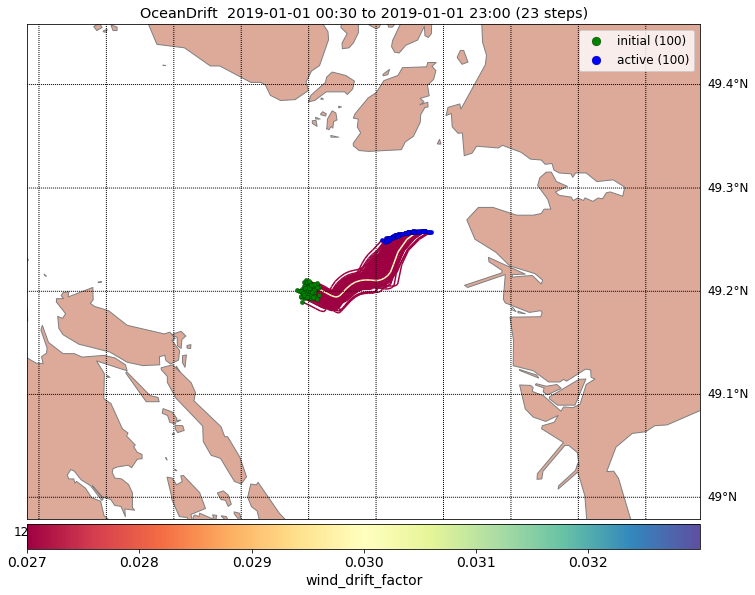

(<mpl_toolkits.basemap.Basemap at 0x7f75ca8005f8>,
 <module 'matplotlib.pyplot' from '/home/bmoorema/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>)

In [15]:
o.plot(linecolor='wind_drift_factor')